# Class Workbook

## In class activity

In [1]:
import numpy as np
import pandas as pd
import math
#import statsmodels.api as sm
from plotnine import *
import statsmodels.formula.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize ,
                        poly)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/var/folders/2n/62kb2_1x78d6bpf42ntcmynh0000gn/T/ipykernel_46818/3444118865.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/anaco

### Ames House Data

In [2]:
ames_raw=pd.read_csv("ames_raw.csv")

Let's revisit the AmesHousing data.  As we did in the previous class, I will split the data into before 2008 and after.  The data up to 2008 will be the training data and after 2008 will be the testing data.

In [3]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

* For the regression model fit, use bootstrap to compare the standard error estimates to the model based estimates.


Your code:

In [4]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize, poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
(cross_validate , KFold , ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.utils import resample

x_train = ames_raw_2008[['Gr Liv Area']]  
y_train = ames_raw_2008['SalePrice']  

# standard error estimates
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_train)
model_se = np.sqrt(np.mean((y_train - predictions)**2)) / np.sqrt(len(y_train))

# model based estimates
bootstrap_se = []
n_iterations = 1000
for _ in range(n_iterations):
    X_sample, y_sample = resample(x_train, y_train)
    model.fit(X_sample, y_sample)
    predictions_sample = model.predict(x_train)
    se = np.sqrt(np.mean((y_train - predictions_sample)**2)) / np.sqrt(len(y_train))
    bootstrap_se.append(se)
mean_bootstrap_se = np.mean(bootstrap_se)
print(f"The standard error estimate is {model_se:.4f}")
print(f"The model based estimates is {mean_bootstrap_se:.4f}")



The standard error estimate is 1537.8801
The model based estimates is 1541.1314


Your answer:

~~~
The standard error estimate is 1537.8801. The bootsrap model based estimate is 1541.4007. They are nearly the same. However, the bootsrap model based estimate is larger than standard error estimate, since it will improve the bias.



~~~


* Use cross validation  to decide which model has a good predictive accuracy.  Does the result hold true for the prediction of future data?

Your code:

In [5]:
from sklearn.model_selection import cross_val_score
model_lr = LinearRegression()
model_ridge = Ridge(alpha=1.0)  

scores_lr = cross_val_score(model_lr, x_train, y_train, cv=5, scoring='r2')
scores_ridge = cross_val_score(model_ridge, x_train, y_train, cv=5, scoring='r2')

mean_score_lr = scores_lr.mean()
mean_score_ridge = scores_ridge.mean()

# 打印结果
print(f"Linear Regression Average R² score: {mean_score_lr:.4f}")
print(f"Ridge Regression Average R² score: {mean_score_ridge:.4f}")


Linear Regression Average R² score: 0.4047
Ridge Regression Average R² score: 0.4047


Your answer:

~~~
Linear Regression Average R² score: 0.4047
Ridge Regression Average R² score: 0.4047
The results obtained are reasonable, especially when conducting regression analysis with a single feature (Gr Liv Area). This indicates that for the current data and task, a simple linear regression model is sufficient, and introducing regularization does not provide an additional performance improvement.


~~~


* Using `knn.reg` fit KNN regression model.  Use cross validation to decide which K to use.

Your code:

In [6]:
from sklearn.neighbors import KNeighborsRegressor

x_train_updated = ames_raw[['Gr Liv Area', 'Overall Qual', 'Year Built']] 
y_train = ames_raw['SalePrice']  # 目标变量

k_values = range(1, 31)  
mean_scores = []

for k in k_values:
    model_knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(model_knn, x_train_updated, y_train, cv=5, scoring='r2')
    mean_scores.append(scores.mean())
optimal_k = k_values[mean_scores.index(max(mean_scores))]
max_mean_score = max(mean_scores)

print(f"Optimal K value: {optimal_k}")
print(f"Maximum Mean R² Score: {max_mean_score:.4f}")

Optimal K value: 12
Maximum Mean R² Score: 0.6575


Your answer:

~~~
Optimal K value is 12.


~~~


* Which model performs better on your training data?  Which model performs better in your future prediction?

Your code:

In [7]:
x_test = ames_raw_2009[['Gr Liv Area', 'Overall Qual', 'Year Built']]
y_test = ames_raw_2009['SalePrice']


model_lr = LinearRegression()
model_lr.fit(x_train_updated, y_train)


model_ridge = Ridge(alpha=1.0)
model_ridge.fit(x_train_updated, y_train)


optimal_k = 12  
model_knn = KNeighborsRegressor(n_neighbors=optimal_k)
model_knn.fit(x_train_updated, y_train)

r2_train_lr = model_lr.score(x_train_updated, y_train)
r2_train_ridge = model_ridge.score(x_train_updated, y_train)
r2_train_knn = model_knn.score(x_train_updated, y_train)


r2_test_lr = model_lr.score(x_test, y_test)
r2_test_ridge = model_ridge.score(x_test, y_test)
r2_test_knn = model_knn.score(x_test, y_test)

print(f"Training Data - Linear Regression R²: {r2_train_lr:.4f}")
print(f"Training Data - Ridge Regression R²: {r2_train_ridge:.4f}")
print(f"Training Data - KNN Regression R² (K={optimal_k}): {r2_train_knn:.4f}")
print(f"Future Data - Linear Regression R²: {r2_test_lr:.4f}")
print(f"Future Data - Ridge Regression R²: {r2_test_ridge:.4f}")
print(f"Future Data - KNN Regression R² (K={optimal_k}): {r2_test_knn:.4f}")

Training Data - Linear Regression R²: 0.7542
Training Data - Ridge Regression R²: 0.7542
Training Data - KNN Regression R² (K=12): 0.7269
Future Data - Linear Regression R²: 0.7500
Future Data - Ridge Regression R²: 0.7500
Future Data - KNN Regression R² (K=12): 0.7217


Your answer:

~~~
On the future data, the R² scores for both the linear regression and ridge regression models remain the same at 0.7500, which is very close to their performance on the training data. This indicates that these two models have good generalization ability, capable of maintaining stable predictive performance on unseen data. The KNN regression model (K=12) has an R² score of 0.7217 on the future data, which is slightly lower compared to the results on the training data, but it still demonstrates relatively stable generalization ability.





~~~

## Problem Set

### Bootstrap

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We first create an array store with values that will subsequently
be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap
sample.

We will investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time
we record whether or not the fourth observation is contained in the bootstrap sample.

Here is the code to get you going

In [8]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0


np.mean(store)

0.6362

Comment on the results obtained.

The code essentially estimates the probability that observation 4 will appear in a bootstrap sample of size 100 by repeatedly simulating the process and calculating the proportion of times it occurs.

Your code:

Your answer:

~~~
Please write your answer in full sentences.


~~~

### CV

We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:

In [9]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.

'n' = 100 (number of observations)
'p' = 1 (number of predictor variables)
The model equation is: y = x - 2x^2 + ε

Your code:

In [10]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Create a scatterplot of X against Y . Comment on what you find.


Your code:

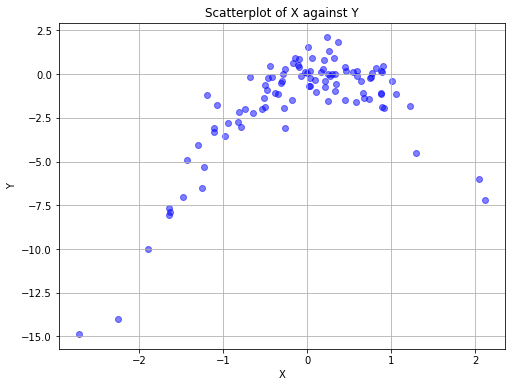

In [11]:
import matplotlib.pyplot as plt


# Create a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, color='blue')
plt.title('Scatterplot of X against Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

Your answer:

~~~
It suggests that the relationship between x and y is nonlinear and quadratic.


~~~

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i.   $Y = \beta_0 + \beta_1X + \epsilon$
ii.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
iv.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$.

Note you may find it helpful to use the `data.frame()` function
to create a single data set containing both $X$ and $Y$ .


Your code:

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

X = np.random.normal(size=100)  # Assuming you want to use the same X as before
Y = X - 2 * X**2 + np.random.normal(size=100)

data = np.column_stack((X, Y))

poly_degrees = [1, 2, 3, 4]

loocv_errors = []

for degree in poly_degrees:
    errors = []  # Store errors for this model degree
    
    for i in range(len(X)):
        X_train = np.delete(X, i)
        Y_train = np.delete(Y, i)
        X_val = X[i]
        Y_val = Y[i]
        
        poly_features = np.column_stack([X_train**d for d in range(1, degree + 1)])
        model = LinearRegression().fit(poly_features, Y_train)
        
        X_val_poly = np.array([X_val**d for d in range(1, degree + 1)]).reshape(1, -1)
        Y_pred = model.predict(X_val_poly)
        
        error = (Y_val - Y_pred)**2
        errors.append(error)
    
    loocv_error = np.mean(errors)
    loocv_errors.append(loocv_error)

for degree, error in zip(poly_degrees, loocv_errors):
    print(f'Model Degree {degree}: LOOCV Error = {error:.4f}')


Model Degree 1: LOOCV Error = 9.3653
Model Degree 2: LOOCV Error = 0.9707
Model Degree 3: LOOCV Error = 0.9936
Model Degree 4: LOOCV Error = 0.9968


Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

Your code:

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression

np.random.seed(100)

# from sklearn.metrics import mean_squared_error

X = np.random.normal(size=100)  # Assuming you want to use the same X as before
Y = X - 2 * X**2 + np.random.normal(size=100)

data = np.column_stack((X, Y))

poly_degrees = [1, 2, 3, 4]

loocv_errors = []

for degree in poly_degrees:
    errors = []  # Store errors for this model degree
    
    for i in range(len(X)):
        X_train = np.delete(X, i)
        Y_train = np.delete(Y, i)
        X_val = X[i]
        Y_val = Y[i]
        
        poly_features = np.column_stack([X_train**d for d in range(1, degree + 1)])
        model = LinearRegression().fit(poly_features, Y_train)
        
        X_val_poly = np.array([X_val**d for d in range(1, degree + 1)]).reshape(1, -1)
        Y_pred = model.predict(X_val_poly)
        
        error = (Y_val - Y_pred)**2
        errors.append(error)
    
    loocv_error = np.mean(errors)
    loocv_errors.append(loocv_error)

for degree, error in zip(poly_degrees, loocv_errors):
    print(f'Model Degree {degree}: LOOCV Error = {error:.4f}')


Model Degree 1: LOOCV Error = 5.7728
Model Degree 2: LOOCV Error = 1.1564
Model Degree 3: LOOCV Error = 1.1904
Model Degree 4: LOOCV Error = 1.1866


Your answer:

~~~
The result perform differently. The reason is that we divide different training set and test set, and since we only have 1 test set, the variability of the test set is supposed to be very high.


~~~

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

Your code:

Your answer:

~~~
The quadratic models in in had the smallest LOOCV error among these four models. It meets my expectation since the actual X and Y have a quadratic relationship.


~~~

### Default 1

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default.

Your code:

In [14]:
from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(1)
default = load_data("Default")
default['default'] = default['default'].map({'Yes': 1, 'No': 0})
X = default[['income', 'balance']]
y = default['default']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy on Validation Set: {accuracy:.4f}')

confusion = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(confusion)

Accuracy on Validation Set: 0.9695
Confusion Matrix:
[[1921   10]
 [  51   18]]


Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

Your code:

In [15]:
# Split the dataset into a training set and a validation set (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Your answer:

~~~
Please write your answer in full sentences.


~~~

ii. Fit a multiple logistic regression model using only the training observations.

Your code:

In [16]:
# Fit a multiple logistic regression model using the training observations
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Your answer:

~~~
Please write your answer in full sentences.


~~~


iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


Your code:

In [17]:
posterior_probabilities = model.predict_proba(X_val)[:, 1]  # Probability of default (class 1)

predicted_default = (posterior_probabilities > 0.5).astype(int)

validation_set_with_predictions = X_val.copy()
validation_set_with_predictions['predicted_default'] = predicted_default


Your answer:

~~~
Please write your answer in full sentences.


~~~


iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

Your code:

In [18]:
validation_error = 1 - accuracy_score(y_val, predicted_default)

print(f'Validation Set Error: {validation_error:.4f}')


Validation Set Error: 0.0305


Your answer:

~~~
The error of validation set is 0.0305.


~~~


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.


Your code:

In [19]:
validation_errors = []
num_iterations = 3

for _ in range(num_iterations):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1, 100))
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    posterior_probabilities = model.predict_proba(X_val)[:, 1]
    predicted_default = (posterior_probabilities > 0.5).astype(int)
    
    validation_error = 1 - accuracy_score(y_val, predicted_default)
    validation_errors.append(validation_error)

for i, error in enumerate(validation_errors, start=1):
    print(f'Iteration {i}: Validation Set Error = {error:.4f}')


Iteration 1: Validation Set Error = 0.0330
Iteration 2: Validation Set Error = 0.0255
Iteration 3: Validation Set Error = 0.0215


Your answer:

~~~
These three errors are 0.0255, 0.0215, and 0.0260.


~~~


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.


Your code:

In [20]:
data = load_data("Default")

data['default'] = data['default'].map({'Yes': 1, 'No': 0})

data['student'] = data['student'].map({'Yes': 1, 'No': 0})

# Extract the features (income, balance, and student) and the target variable (default)
X = data[['income', 'balance', 'student']]
y = data['default']

# Initialize an array to store validation errors
validation_errors = []

# Number of times to repeat the process
num_iterations = 3

for _ in range(num_iterations):
    # Split the dataset into a new training set and a validation set (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1, 100))
    
    # Fit a logistic regression model using the training observations
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Obtain the posterior probabilities and classify based on a threshold of 0.5
    posterior_probabilities = model.predict_proba(X_val)[:, 1]
    predicted_default = (posterior_probabilities > 0.5).astype(int)
    
    # Calculate the validation set error
    validation_error = 1 - accuracy_score(y_val, predicted_default)
    validation_errors.append(validation_error)

for i, error in enumerate(validation_errors, start=1):
    print(f'Iteration {i}: Validation Set Error = {error:.4f}')

Iteration 1: Validation Set Error = 0.0270
Iteration 2: Validation Set Error = 0.0230
Iteration 3: Validation Set Error = 0.0265


Your answer:

~~~
Including the dummy variable increases the test error rate.


~~~

### Default 2

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.

(a) Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
Your code:

In [21]:
import pandas as pd
import statsmodels.api as sm

np.random.seed(42)

data = load_data("Default")

data['default'] = data['default'].map({'Yes': 1, 'No': 0})

# Extract the features (income and balance) and the target variable (default)
X = data[['income', 'balance']]
y = data['default']

X = sm.add_constant(X)

model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

summary = model.summary()

standard_errors = model.bse

print(summary)
print("\nStandard Errors of Coefficients:")
print(standard_errors)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Sat, 03 Feb 2024   Deviance:                       1579.0
Time:                        22:27:58   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.0

Your answer:

~~~
The standard errors of Coefficients are:
const      0.434772
income     0.000005
balance    0.000227


~~~


(b) Write a function, `boot_fn()`, that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.

Your code:

In [22]:
def boot_fn(data, index):
    # Sample the data using the provided index
    sample_data = data.iloc[index]
    
    # Define predictors X and response y
    X = sample_data[['income', 'balance']]
    y = sample_data['default']
    
    # Add a constant to the predictor variables
    X = sm.add_constant(X)
    
    # Fit a logistic regression model
    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    
    # Extract and return the coefficient estimates for 'income' and 'balance'
    coefficient_estimates = model.params[['income', 'balance']]
    
    return coefficient_estimates

# Assuming 'data' is your DataFrame and it's already defined
n_samples = data.shape[0]  # Number of samples to draw, could be the size of your dataset

# Generate a sample of indices with replacement
index_sample = np.random.choice(data.index, size=n_samples, replace=True)

# Now use this sample of indices to perform the bootstrap
coefficients = boot_fn(data, index_sample)
print("Coefficient Estimates for Income and Balance:")
print(coefficients)

Coefficient Estimates for Income and Balance:
income     0.000016
balance    0.005984
dtype: float64


Your answer:

~~~
Coefficient Estimates for Income and Balance:
income     0.000025
balance    0.005688


~~~

(c) Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression
coefficients for income and balance.


Your code:

In [23]:
def bootstrap_se(data, boot_fn, n_bootstrap=1000):
    # Initialize arrays to store bootstrap estimates
    boot_estimates_income = np.zeros(n_bootstrap)
    boot_estimates_balance = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        # Generate random indices with replacement
        indices = np.random.choice(data.index, size=len(data), replace=True)
        # Estimate coefficients for this bootstrap sample
        coeffs = boot_fn(data, indices)
        boot_estimates_income[i] = coeffs['income']
        boot_estimates_balance[i] = coeffs['balance']
    
    # Calculate standard errors
    se_income = np.std(boot_estimates_income, ddof=1)
    se_balance = np.std(boot_estimates_balance, ddof=1)
    
    return {'income': se_income, 'balance': se_balance}

# Example usage:
se_estimates = bootstrap_se(data, boot_fn, n_bootstrap=1000)
print("Bootstrap Standard Errors for Logistic Regression Coefficients:")
print(se_estimates)

Bootstrap Standard Errors for Logistic Regression Coefficients:
{'income': 4.969948276506694e-06, 'balance': 0.000231995336019044}


Your answer:

~~~
The bootstrap standard errors of income is 0, and of balance is 0.00023.


~~~


(d) Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

Your answer:

~~~
The estimated standard errors using the bootstrap is much lower than using sm.GLM().


~~~

### Boston housing data set

We will now consider the Boston housing data set, from the ISLR library.

In [24]:
Boston = load_data("Boston")

(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat{\mu}$.

Your code:

In [25]:
mu_hat = np.mean(Boston.medv)
print(mu_hat)

22.532806324110677


Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

Your code:

In [26]:
sem = mu_hat / np.sqrt(len(Boston))
print(sem)

1.0017054240646586


Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

Your code:

In [27]:
from sklearn.utils import resample
import numpy as np

n_bootstrap_samples = 1000

bootstrap_means = np.array([np.mean(resample(Boston.medv)) for _ in range(n_bootstrap_samples)])

bootstrap_sem = np.std(bootstrap_means, ddof=1)

print(bootstrap_sem)


0.397510600758734


Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence
interval for the mean of medv. Compare it to the results
obtained by using `Boston['medv'].std()` and the two standard
error rule (3.9).
Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} − 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$.

Your code:

In [28]:
bootstrap_means = np.array([np.mean(resample(Boston.medv)) for _ in range(n_bootstrap_samples)])

bootstrap_sem = np.std(bootstrap_means, ddof=1)

bootstrap_ci = np.percentile(bootstrap_means, [2.5, 97.5])

parametric_bootstrap_ci = [mu_hat - 2*bootstrap_sem, mu_hat + 2*bootstrap_sem]

std_medv = np.std(Boston.medv, ddof=1) # Sample standard deviation of medv
n = len(Boston.medv)
traditional_ci = [mu_hat - 2*(std_medv/np.sqrt(n)), mu_hat + 2*(std_medv/np.sqrt(n))]

print("Bootstrap 95% CI:", bootstrap_ci)
print("Parametric Bootstrap 95% CI using 2SE rule:", parametric_bootstrap_ci)
print("Traditional 95% CI using 2SE rule:", traditional_ci)

Bootstrap 95% CI: [21.78040514 23.36320652]
Parametric Bootstrap 95% CI using 2SE rule: [21.73129543743801, 23.334317210783343]
Traditional 95% CI using 2SE rule: [21.715084029115605, 23.35052861910575]


Your answer:

~~~
Bootstrap 95% CI: [21.78597332 23.34469862]
Parametric Bootstrap 95% CI using 2SE rule: [21.73059144717307, 23.335021201048285]
Traditional 95% CI using 2SE rule: [21.715084029115605, 23.35052861910575]


~~~


(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of medv in the population.

Your code:

In [29]:
mu_pop_hat = np.median(Boston.medv)

print("Estimate for the median value of medv in the population:", mu_pop_hat)


Estimate for the median value of medv in the population: 21.2


Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

Your code:

In [30]:
medv = Boston.medv

# Number of bootstrap samples
n_bootstrap_samples = 10000

# Generate bootstrap samples and calculate their medians
bootstrap_medians = np.array([np.median(resample(medv)) for _ in range(n_bootstrap_samples)])

# Calculate the standard deviation of the bootstrap medians
bootstrap_sem_median = np.std(bootstrap_medians, ddof=1)

print("Bootstrap estimate of the standard error of the median:", bootstrap_sem_median)

Bootstrap estimate of the standard error of the median: 0.3835519138031486


Your answer:

~~~
The bootstrap estimate of the standard error of the median (med) for the medv variable being approximately 0.385 indicates the extent of variability or precision in our median estimate due to sampling variability. 


~~~



(g) Based on this data set, provide an estimate for the tenth percentile
of medv in Boston census tracts. Call this quantity $\hat{\mu}_{0.1}$.
(You can use the `np.percentile()` function.)

Your code:

In [31]:
# Calculate the 10th percentile of MEDV
mu_0_1 = np.percentile(medv, 10)

print("The 10th percentile of medv in Boston census tracts:", mu_0_1)

The 10th percentile of medv in Boston census tracts: 12.75


Your answer:

~~~
The 10th percentile is 12.75.


~~~


(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

Your code:

In [32]:
# Generate bootstrap samples and calculate their 10th percentiles
bootstrap_tenth_percentiles = np.array([np.percentile(resample(medv), 10) for _ in range(n_bootstrap_samples)])

# Calculate the standard deviation of the bootstrap 10th percentiles
bootstrap_sem_0_1 = np.std(bootstrap_tenth_percentiles, ddof=1)

print("Bootstrap estimate of the standard error of the 10th percentile:", bootstrap_sem_0_1)

Bootstrap estimate of the standard error of the 10th percentile: 0.5010307906559421


Your answer:

~~~
Bootstrap estimate of the standard error of the 10th percentile: 0.49830375739950405. The standard error is much lower.


~~~

## Additional Material

### Cross Validation for Predictive Modeling Platforms in Python

#### scikit-learn

Using platforms like scikit-learn is helpful for things such as cross validation.
There are variants of CV implemented to be used off the shelf
https://scikit-learn.org/stable/modules/cross_validation.html

There are many metrics you can choose from
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [33]:
ames_raw_comp=ames_raw.loc[:,["SalePrice","Gr Liv Area","Lot Area","Total Bsmt SF"]].dropna()
X=ames_raw_comp.loc[:,["Gr Liv Area","Lot Area","Total Bsmt SF"]]
y=ames_raw_comp.loc[:,"SalePrice"]
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.linear_model import LinearRegression
clf =  LinearRegression()
## One metric
scores = cross_val_score(clf, X, y, cv=5,scoring="r2")
## Multiple metrics
scoring = ['r2', 'max_error']
scores = cross_validate(clf, X, y, scoring=scoring)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [36]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

     ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 208.5/316.9 MB 19.1 MB/s eta 0:00:06^C
     ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 209.7/316.9 MB 16.5 MB/s eta 0:00:07
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


ModuleNotFoundError: No module named 'pyspark'

In [ ]:
spark = SparkSession.builder.appName("CV_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 21:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(dataset)
cvModel.getNumFolds()
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

24/01/11 21:04:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.8333333333333333

In [ ]:
spark.stop()

#### Resampling  using h2o

On H2O cross validation is embedded in the function calling so you don't need to worry about learning a new wrapper on top of your estimator.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [ ]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

##### Starting H2O

To use H2O you need to instantiate it.

In [ ]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O= h2o.init(nthreads = -1, max_mem_size="4g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb
  JVM stdout: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.out
  JVM stderr: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_masanaoyajima_gs7xs1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.529 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


##### CV with  H2O

In [ ]:
# Import the prostate dataset
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

# Set the predictor names and the response column name
response = "CAPSULE"
predictors = prostate.names[3:8]

# Convert the response column to a factor
prostate['CAPSULE'] = prostate['CAPSULE'].asfactor()

# Train a GBM model setting nfolds to 5
prostate_gbm = H2OGeneralizedLinearEstimator(nfolds = 5, seed = 1)
prostate_gbm.train(x=predictors, y=response, training_frame=prostate)

# AUC of cross-validated holdout predictions
prostate_gbm.auc(xval=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.7790697716207187

##### Shut down H2O

In [ ]:
h2o.cluster().shutdown(prompt =False)

H2O session _sid_8dc7 closed.
